In [1]:
import pandas as pd

In [10]:
df = pd.read_csv('final_VIF_Delete.csv', index_col=0)

In [11]:
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_INCOME_TYPE_1.0,NAME_INCOME_TYPE_2.0,NAME_INCOME_TYPE_3.0,NAME_FAMILY_STATUS_2.0,NAME_FAMILY_STATUS_3.0
0,1,0,0,0,1,0.0,0.615,-0.198521,-0.011205,0.0,...,0,0,0,0.0,0.0,0,0,0,1,0
1,1,0,1,0,1,0.0,-0.385,0.865982,0.120269,0.0,...,0,0,0,0.0,0.5,0,0,0,0,1
2,1,0,0,0,1,0.0,0.615,1.262506,0.560259,0.0,...,0,0,0,0.0,1.5,1,0,0,0,0
3,1,0,1,0,0,0.0,-0.135,-0.417076,-0.478337,0.0,...,0,0,0,0.0,0.5,0,0,0,0,0
4,1,0,1,0,1,0.0,-0.735,-0.485530,-0.570468,0.0,...,0,0,0,0.0,-0.5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0,0,1,0,1,0.0,-0.385,-0.535656,-0.157869,0.0,...,0,0,0,0.0,-0.5,0,1,0,1,0
307503,0,0,0,0,0,0.0,0.115,-0.480518,0.146912,0.0,...,0,0,0,0.0,0.0,0,0,0,0,1
307504,0,0,1,0,1,0.0,-0.835,-0.452949,-0.713894,0.0,...,0,0,0,0.0,0.0,0,1,0,0,1
307505,0,0,1,0,1,0.0,0.065,0.304712,0.280876,0.0,...,0,0,0,1.0,0.0,0,0,0,0,1


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm

def perform_logistic_regression(X, y, test_size=0.2, random_state=42):
    """
    Perform logistic regression with comprehensive analysis
    
    Parameters:
    X: Features DataFrame
    y: Target Series
    test_size: Size of test set (default: 0.2)
    random_state: Random state for reproducibility
    """
    # 1. Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        stratify=y,
                                                        random_state=random_state)
    
    # 2. Model Training
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    
    # 3. Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 4. Model Evaluation
    print("Model Performance:")
    print("=" * 50)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 5. ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    # 6. Cross Validation Score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\nCross Validation ROC-AUC Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # 7. Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0]
    })
    feature_importance = feature_importance.sort_values('Coefficient', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # 8. Visualization
    plt.figure(figsize=(15, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return model, feature_importance

def get_feature_significance(X, y):
    """
    Calculate p-values for features using training data only
    
    Parameters:
    X: Features DataFrame
    y: Target Series
    """
    # Train-Test Split
    X_train, _, y_train, _ = train_test_split(X, y, 
                                             test_size=0.2, 
                                             stratify=y, 
                                             random_state=42)
    
    X_with_const = sm.add_constant(X_train)
    model = sm.Logit(y_train, X_with_const)
    results = model.fit()
    
    feature_significance = pd.DataFrame({
        'Feature': ['const'] + list(X_train.columns),
        'P-value': results.pvalues,
        'Coefficient': results.params
    })
    
    return feature_significance.sort_values('P-value')


Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56537
           1       0.45      0.11      0.18      4965

    accuracy                           0.92     61502
   macro avg       0.69      0.55      0.57     61502
weighted avg       0.89      0.92      0.89     61502


ROC-AUC Score: 0.8460

Cross Validation ROC-AUC Scores: [0.84578993 0.84520149 0.84436908 0.84413635 0.84744464]
Mean CV Score: 0.8454 (+/- 0.0024)

Top 10 Most Important Features:
                 Feature  Coefficient
35       FLAG_DOCUMENT_2     1.220636
54      FLAG_DOCUMENT_21     0.529930
36       FLAG_DOCUMENT_3     0.434604
38       FLAG_DOCUMENT_5     0.392869
41       FLAG_DOCUMENT_8     0.307071
40       FLAG_DOCUMENT_7     0.298769
59  NAME_INCOME_TYPE_3.0     0.296154
42       FLAG_DOCUMENT_9     0.295612
39       FLAG_DOCUMENT_6     0.253626
20       OCCUPATION_TYPE     0.174775


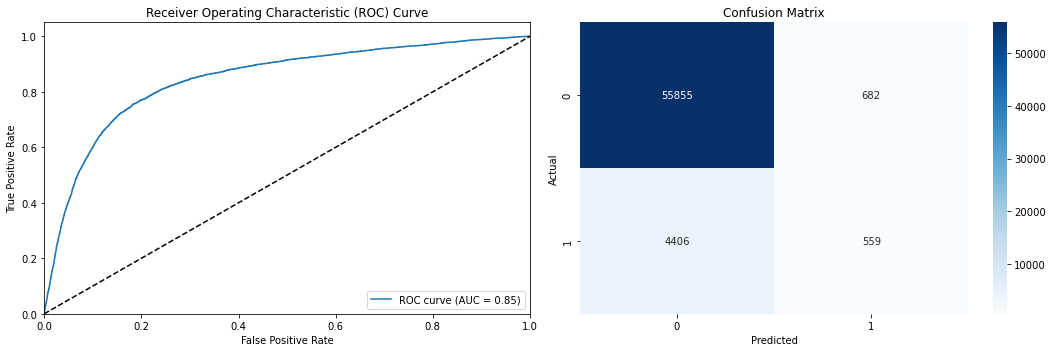

In [13]:
# Target 변수와 특성 변수 분리
X = df.drop('TARGET', axis=1)  # TARGET 열을 제외한 모든 열
y = df['TARGET']  # TARGET 열만 선택

# 이렇게 준비된 X, y로 로지스틱 회귀 실행
model, feature_importance = perform_logistic_regression(X, y)

Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.44      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.68      0.51      0.51     61502
weighted avg       0.88      0.92      0.88     61502


ROC-AUC Score: 0.7833

Cross Validation ROC-AUC Scores: [0.781607   0.77889842 0.77946809 0.78182592 0.77902448]
Mean CV Score: 0.7802 (+/- 0.0026)

Top 10 Most Important Features:
                 Feature  Coefficient
34       FLAG_DOCUMENT_2     1.215117
58  NAME_INCOME_TYPE_3.0     0.615957
35       FLAG_DOCUMENT_3     0.421388
37       FLAG_DOCUMENT_5     0.364088
38       FLAG_DOCUMENT_6     0.331886
52      FLAG_DOCUMENT_20     0.273517
40       FLAG_DOCUMENT_8     0.246395
20       OCCUPATION_TYPE     0.212948
41       FLAG_DOCUMENT_9     0.200773
17       FLAG_WORK_PHONE     0.168926


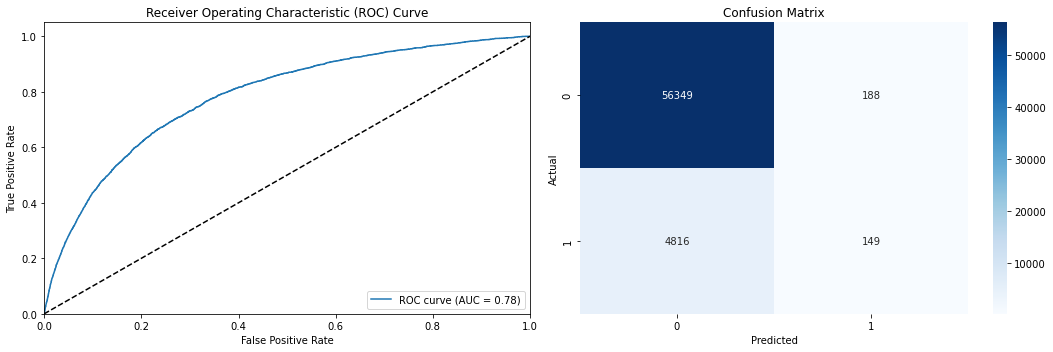

In [14]:
features = [col for col in df.columns if 'EXT_SOURCE_1' not in col and col != 'TARGET']
X_drop = df[features]
y_drop = df['TARGET']

model_2, feature_importance_2 = perform_logistic_regression(X_drop, y_drop)

In [15]:
def evaluate_model(model, X_test_new, y_test_new):
    """
    Evaluate model performance on new test data
    
    Parameters:
    model: Trained LogisticRegression model
    X_test_new: New test features
    y_test_new: New test target
    """
    # Predictions
    y_pred = model.predict(X_test_new)
    y_pred_proba = model.predict_proba(X_test_new)[:, 1]
    
    # Performance Metrics
    print("Model Performance on New Test Data:")
    print("=" * 50)
    
    print("\nClassification Report:")
    print(classification_report(y_test_new, y_pred))
    
    roc_auc = roc_auc_score(y_test_new, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test_new, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (New Test Data)')
    plt.legend(loc="lower right")
    
    # Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test_new, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (New Test Data)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc

# 사용 예시:
"""
# 1. 먼저 모델 학습
model, feature_importance = perform_logistic_regression(X, y)

# 2. 새로운 테스트 데이터로 평가
roc_auc_new = evaluate_model(model, X_test_new, y_test_new)
"""

'\n# 1. 먼저 모델 학습\nmodel, feature_importance = perform_logistic_regression(X, y)\n\n# 2. 새로운 테스트 데이터로 평가\nroc_auc_new = evaluate_model(model, X_test_new, y_test_new)\n'

In [17]:
df_test = pd.read_csv('test_final_VIF_Delete.csv', index_col=0)

In [18]:
df_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_INCOME_TYPE_1.0,NAME_INCOME_TYPE_2.0,NAME_INCOME_TYPE_3.0,NAME_FAMILY_STATUS_2,NAME_FAMILY_STATUS_3
0,0,1,0,1,0.0,-0.20,0.286707,-0.290151,0.0,1.0,...,0,0,0,0.0,-0.5,0,0,0,0,0
1,0,0,0,1,0.0,-0.52,-0.548393,-0.454461,0.0,0.0,...,0,0,0,0.0,1.0,0,0,0,0,0
2,0,0,1,1,0.0,0.40,0.514683,2.244496,1.0,1.0,...,0,0,0,0.0,1.5,0,0,0,0,0
3,0,1,0,1,2.0,1.40,2.715030,1.175435,0.0,0.0,...,0,0,0,0.0,1.0,0,0,0,0,0
4,0,0,1,0,1.0,0.20,0.423545,0.302433,0.0,0.0,...,0,0,0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,1,0,1,0.0,-0.32,-0.090356,-0.449131,0.0,0.0,...,0,0,0,0.0,0.0,0,0,0,0,1
48740,0,1,0,0,2.0,0.00,0.416095,0.294322,0.0,0.0,...,0,0,0,0.0,0.0,1,0,0,0,0
48741,0,1,1,1,1.0,0.40,-0.325804,0.361066,0.0,0.0,...,0,0,0,0.0,0.0,1,0,0,0,0
48742,0,0,0,0,0.0,0.60,0.000000,-0.054925,1.0,1.0,...,0,0,0,0.0,0.5,1,0,0,0,0


In [ ]:
test_X = df_test.drop('TARGET', axis=1)  # TARGET 열을 제외한 모든 열
test_y = df['TARGET']  # TARGET 열만 선택